In [1]:
import os
import glob
import wget
import re
import datetime
import astropy
from astropy.time import Time

# plotting and data management
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import rasterio
from rasterio.plot import show as rioshow

os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
from shapely.geometry import Polygon
from geospatial_functions import get_background_map

# scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup

In [9]:
# loading other layers
outline           = gpd.read_file(f"Data\\lena_basin_outline_polygon.gpkg",driver="GPKG")
main_rivers       = gpd.read_file(f"Data\\lena_main_river.gpkg",driver="GPKG") 
coast             = gpd.read_file(f"Data\\north_east_russian_coastlines.gpkg",driver="GPKG") 
eurasian_coast             = gpd.read_file(f"Data\\eurasian_coastlines.gpkg",driver="GPKG") 
# gdf_station       = gdf_station.drop(columns=["site_no"])

# fixing crs
for layer in [outline,main_rivers,coast]:
    layer.geometry = layer.geometry.to_crs("EPSG:4326")

+proj=aea +lat_1=50 +lat_2=70 +lat_0=56 +lon_0=100 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m +no_defs 

In [3]:
crs = "epsg:3395"
outline_local_crs = outline.copy()
outline_local_crs.geometry = outline_local_crs.geometry.to_crs(crs)
main_rivers_local = main_rivers.copy()
main_rivers_local.geometry = main_rivers_local.geometry.to_crs(crs)

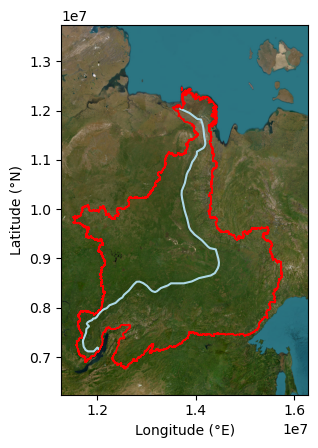

In [4]:
fig, ax  = plt.subplots()
outline_local_crs.plot(ax=ax,edgecolor='red',zorder=10,facecolor="None")
main_rivers_local.plot(ax=ax, color='lightblue')

bounds_stations = (101.493054253, 50.88931030940004, 143.43669891900012, 75.08938842260008) # from epsg plot
with rasterio.open(get_background_map("outline", bounds_stations,crs)) as r:
    rioshow(r, ax=ax,zorder=-10)


ax.set_ylabel("Latitude (°N)")
ax.set_xlabel("Longitude (°E)")
fig.savefig("Figures\Lena_Basin_map.png")

In [6]:
print(f"The area of the basin in {outline_local_crs.area.iloc[0]*10**-6:.2f} km^2") # some issue with the projection

The area of the basin in 11254787.18 km^2


In [7]:
area =  2430000 #km^2

In [28]:
def plot_map(ax):
    legend_field = []
    
    # stations
    # gdf_station.loc[[1358000]].plot(ax=ax, markersize=20, color="C1",zorder=10)
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='discharge station'))

    
    outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2)
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    # all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    # add background
    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    # print(bounds_stations)
    with rasterio.open(get_background_map("outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    coast.plot(ax=ax,color='k',zorder=1)
    ax.set_xlim((bounds_stations[0],bounds_stations[2]))
    ax.set_ylim((bounds_stations[1],bounds_stations[3]))
    ax.grid(alpha=0.3)
    ax.set_title("Lena basin")
    ax.set_ylabel("Latitude (°N)")
    ax.set_xlabel("Longitude (°E)")

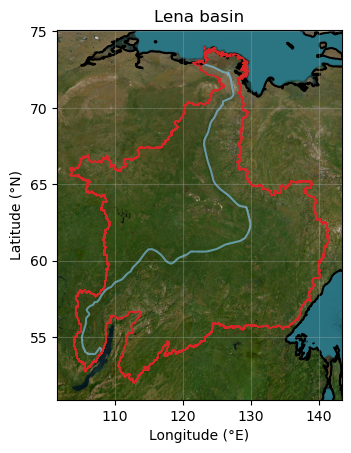

In [29]:
fig, ax = plt.subplots()
plot_map(ax)

fig.savefig("Figures\Lena_Basin_map.png")

In [30]:
def plot_map_overview(ax):
    legend_field = []
    
    # stations
    # gdf_station.loc[[1358000]].plot(ax=ax, markersize=20, color="C1",zorder=10)
    legend_field.append(mpl.lines.Line2D([],[],color='C1',linewidth=0,marker=".",label='discharge station'))

    
    outline.plot(ax=ax, edgecolor="C3", facecolor="None",zorder=2)
    main_rivers.plot(ax=ax, color="lightskyblue",alpha=0.6,zorder=-1,lw=1.5)
    # all_rivers.plot(ax=ax, color="lightskyblue",alpha=0.2,zorder=-2,lw=0.4)
    # add background
    eurasian_coast.plot(ax=ax,color='k',zorder=1)
    bounds_stations = (ax.get_xlim()[0], ax.get_ylim()[0], ax.get_xlim()[1], ax.get_ylim()[1])
    # print(bounds_stations)
    with rasterio.open(get_background_map("eurasian_outline", bounds_stations)) as r:
        rioshow(r, ax=ax,zorder=-10)
    bounds = [60, 10, 150, 80]
    ax.set_xlim((bounds[0],bounds[2]))
    ax.set_ylim((bounds[1],bounds[3]))
    ax.grid(alpha=0.3)
    ax.set_title("Overview of location of lena basin")
    ax.set_ylabel("Latitude (°N)")
    ax.set_xlabel("Longitude (°E)")

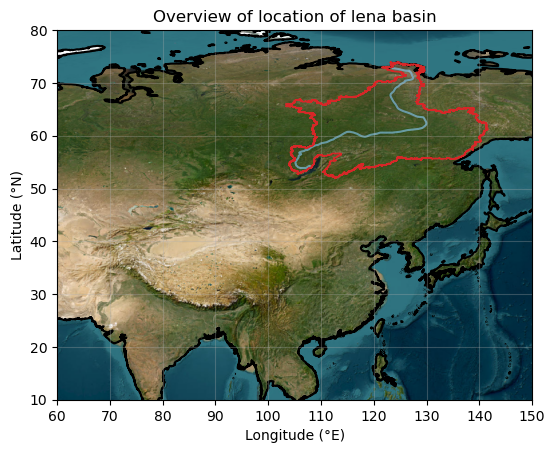

In [31]:
fig, ax = plt.subplots()
plot_map_overview(ax)

fig.savefig("Figures\overview_map.png")

# Q

In [10]:
df = pd.read_excel(f"Data\\Lena_Kyusyur_Version_20230809.xlsx")
df['timestamp'] = df.apply(lambda x: pd.Timestamp(x.date),axis=1)
df.index = df.timestamp

In [11]:
df = df[["discharge"]]

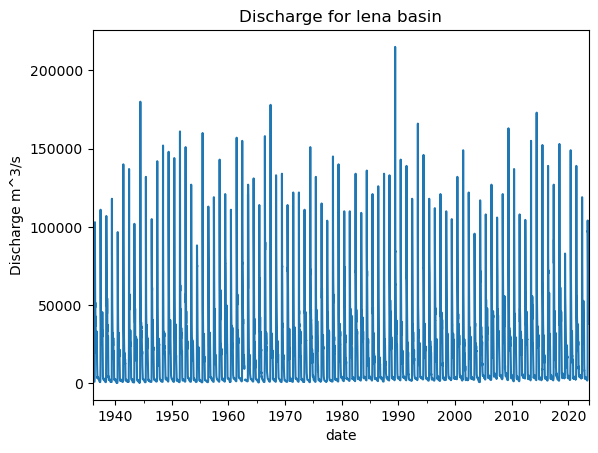

In [12]:
df.discharge.plot()
plt.title('Discharge for lena basin')
plt.ylabel("Discharge m^3/s")
plt.xlabel("date");

In [13]:
df_monthly_Q = df.resample("m").sum()

<Axes: xlabel='timestamp'>

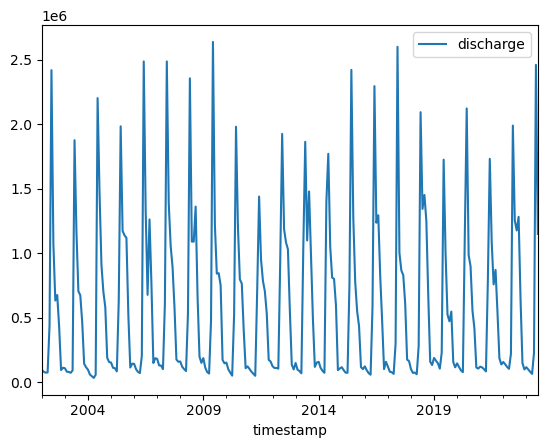

In [14]:
df_monthly_Q.loc["2002":"2023"].plot()

# P & E from era5?

# load grace data

In [17]:
url = "https://ftp.tugraz.at/outgoing/ITSG/GRACE/ITSG-Grace2018/monthly/monthly_n60/"

In [18]:
page = urlopen(url)
html_bytes = page.read()
html = html_bytes.decode("utf-8")

In [19]:
table = html[html.find('<table>'):html.find('</table>')]
table_data = [[cell.text.strip() for cell in row("td")]
                         for row in BeautifulSoup(table)("tr")]
headers = [[cell.text.strip() for cell in row("th")]
                      for row in BeautifulSoup(table)("tr")][0]
table_data = [row for row in table_data if len(row)>2]

In [20]:
array_grace_data_availible = np.array([np.array(row) for row in table_data])[:,1][1:]

In [21]:
if glob.glob('Data\\Grace\*.gfc') == 0: # only run if no data yet
    for grace_data in array_grace_data_availible:
        wget.download(url + grace_data, out=f'Data\\Grace\\{grace_data}')

In [28]:
url_degree_1_stoke_coeff =  "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/grace/open/docs/TN-13_GEOC_CSR_RL0601.txt"
fname1 = f'Data\\Grace\\degree1_stokes_coeff.txt'
if not os.path.exists(fname1):
    wget.download(url_degree_1_stoke_coeff, out=fname1)

In [26]:
url_degree_2_stoke_coeff =  "https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-docs/grace/open/docs/TN-14_C30_C20_GSFC_SLR.txt"
fname2 = f'Data\\Grace\\degree2_stokes_coeff.txt'
if not os.path.exists(fname2):
    wget.download(url_degree_2_stoke_coeff, out=fname2)

100% [..............................................................................] 26673 / 26673

In [87]:
fname_stoke_coeff2 = f'Data\\Grace\\degree2_stokes_coeff.txt'
# df_stokes_2 = np.loadtxt(fname_stoke_coeff2,skiprows=38) 
#         #names=['GRCOF2',"_1","_2","_3","l","_4","_5","m", "Clm","Slm","sd_Clm","sd_Slm","begin_date","end_date"])

In [104]:
reach_end_of_head = False
list_lines = []
with open(fname_stoke_coeff2) as fin:
    for line in fin:
        line = line.strip()
        if not reach_end_of_head:
            if line.startswith("Product:"):
                reach_end_of_head = True
        else:
            line = line.split(' ')
            line = np.array(line)
            line = line[line!=" "]
            line = line[line!=""]
            list_lines.append(line)
arr_lines = np.array(list_lines)

In [151]:
df_stokes_2_3 = pd.DataFrame(arr_lines,
               columns=['MJD begin',"Year fraction begin","C20","C20 - C20_mean (1.0E-10)","sig_C20 (1.0E-10)",
                                                          "C30","C30 - C30_mean (1.0E-10)","sig_C30 (1.0E-10)",
                    'MJD end',"Year fraction end"
                   ])

In [152]:
def MJD_to_ts(mjd):
    # Start with some time in modified julian date (MJD)
    # Convert to Julian Date
    mjd = float(mjd)
    jd = mjd + 2400000.5
    # Convert to astropy Time object
    t = astropy.time.Time(jd, format='jd')
    # Convert to datetime
    str = t.to_datetime()
    return str

In [153]:
df_stokes_2_3["begin_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)
df_stokes_2_3["end_date"] = df_stokes_2_3.apply(lambda x: MJD_to_ts(x['MJD begin']), axis=1)

In [154]:
df_stokes_2_3 = df_stokes_2_3[["begin_date","C20","C30","end_date"]].set_index("begin_date")

,C20,C30,end_date
begin_date,,,
2002-04-04,-4.8416932630052E-04,NaN,2002-04-04
2002-05-02,-4.8416933622892E-04,NaN,2002-05-02
2002-08-01,-4.8416947252201E-04,NaN,2002-08-01
2002-09-01,-4.8416947603407E-04,NaN,2002-09-01
2002-10-01,-4.8416945059861E-04,NaN,2002-10-01
...,...,...,...
2023-03-01,-4.8416969473148E-04,9.5715067897809E-07,2023-03-01
2023-04-01,-4.8416968106076E-04,9.5717273422028E-07,2023-04-01
2023-05-01,-4.8416967094818E-04,9.5718257805354E-07,2023-05-01
